# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|

## Introduction 
Put some introduction here

## Package Instalation and Importing

In [1]:
import sys
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
#!{sys.executable} -m pip install -U mlxtend

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix,plot_roc_curve,precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, NearMiss

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import Counter
from matplotlib import pyplot
from hyperopt import STATUS_OK, fmin, hp, tpe, Trials

In [3]:
def print_df(df):
    return df.style.hide_index().set_properties(**{
    'font-size': '11pt','border': '1pt solid'
    })

In [4]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [5]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


In [6]:
metadata = pd.read_csv("metadata.csv",sep=";")
metadata = metadata.style.hide_index()
metadata.set_properties(**{
    'font-size': '10pt',
})

Name,Description
Citzen_ID,Unique identifier of the citzen.
Name,Name of the citzen
Birthday,The date of birth
Native Continent,The continent of the citzen on Earth
Marital Status,The marital status of the citzen
Lives With,The household environment of the citzen
Base Area,Neighborhood of the Citzen on Newland
Education Level,The education level of the citzen
Year of education,The number the years of education
Employment Sector,The employment sector of the citzen


In [7]:
data.head(5)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [8]:
missing_values_columns = []
for column in data.columns:
    if '?' in data[column].values:
        total = len(data[data[column].str.contains('\?')])
        missing_values_columns.append({'Column': column, 'Total': total})
    if len(data[data[column].isna()]) > 0:
        total = len(data[data[column].isna()])
        missing_values_columns.append({'Column': column, 'Total': total})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df_missing_values = pd.DataFrame(missing_values_columns)
df_missing_values = df_missing_values.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])
df_missing_values = df_missing_values.hide_index()
df_missing_values.set_properties(**{
    'font-size': '11pt','border': '1pt solid'
})

Column,Total
Base Area,395
Employment Sector,1264
Role,1271


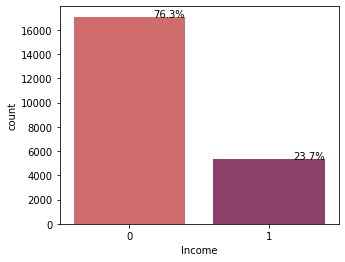

In [10]:
plt.figure(figsize=(5,4))
total = float(len(data))
ax = sns.countplot(x="Income", data=data, color="c",palette='flare')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')

## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [11]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [12]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [13]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [14]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [15]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [16]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [17]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [18]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [19]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [20]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)


    return new_df.copy()

In [21]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [22]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,13,40,0,2273,1,45,10,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12487,12,40,0,0,1,42,9,0,0,0,...,0,0,1,0,0,1,0,1,0,0
12488,12,46,0,2321,1,39,9,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12489,11,37,5395,0,1,63,7,0,0,0,...,0,0,1,0,1,0,0,0,1,0
12490,21,45,0,0,1,33,16,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [23]:
metadata = pd.read_csv("metadata.csv",sep=";")
metadata = metadata.append({'Name': 'Age', 'Description': 'Calculated using the Birthday column'},ignore_index=True)
metadata = metadata.append({'Name': 'Group', 'Description': 'Using the Ticket Price and Money Received columns'},ignore_index=True)
metadata = metadata.append({'Name': 'MStatus', 'Description': 'Binary column to indicates if the candidate is married or not. '},ignore_index=True)
metadata = metadata.append({'Name': 'LWith', 'Description': 'Indicates if the candidate lives alone, with spouse, children or with other relatives'},ignore_index=True)

In [24]:
new_columns = ['Age','Group','MStatus','LWith']
metadata = metadata[metadata['Name'].isin(new_columns)]
metadata.style.hide_index()
metadata = metadata.style.hide_index()
metadata.set_properties(**{
    'font-size': '11pt','border': '1pt solid'
})

Name,Description
Age,Calculated using the Birthday column
Group,Using the Ticket Price and Money Received columns
MStatus,Binary column to indicates if the candidate is married or not.
LWith,"Indicates if the candidate lives alone, with spouse, children or with other relatives"


## Model Creation
In this section, we will create the models.

In [147]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
def runModels(models,X,y,X_test,y_test):

    GlobalTimerStart = time.time()
    ModelPerf = []
    for model in models:
        print(f"Running Model: {type(model).__name__}")
        LocalTimerStart = time.time()
        clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
        model.fit(X,y)
        scoresf1w = cross_validate(model, X,y, cv=10,scoring=('f1_micro'))
        
        labels_train = model.predict(X)        
        labels_val = model.predict(X_test)
        
        print(confusion_matrix(y_test, labels_val))
        
        train_precision = precision_score(y, labels_train, average='micro')
        test_precision = precision_score(y_test, labels_val, average='micro')
        
        train_recall = recall_score(y, labels_train, average='micro')
        test_recall = recall_score(y_test, labels_val, average='micro')
        
        roc_auc_train = roc_auc_score(y, labels_train, average='micro')
        roc_auc_test = roc_auc_score(y_test, labels_val, average='micro')
        
        
        ModelPerf.append((type(model).__name__,
                          'Train',
                          scoresf1w['test_score'].mean(),
                          train_precision,
                          train_recall,
                          roc_auc_train
        ))
        ModelPerf.append((type(model).__name__,
          'Test',
          f1_score(y_test, labels_val, average='micro'),
          test_precision,
          test_recall,
          roc_auc_test
        ))
        
        LocalTimerEnd = time.time()
        print(f"-- Done. Duration: {LocalTimerEnd-LocalTimerStart} s")
    GlobalTimerEnd = time.time()
    print(f"GLOBAL DURATION: {GlobalTimerEnd-GlobalTimerStart} s")
    
    res = pd.DataFrame(ModelPerf,columns=['model','Stage','f1_micro', 'precision_micro', 'recall_micro','roc_auc_micro'])
    
    
    fig = plt.figure(figsize=(20, 10))
    graph = sns.barplot(x="model", y="f1_micro", hue="Stage", data=res, palette='flare')
    graph.legend(loc='lower left')
    for bar in graph.patches:
        graph.annotate(format(bar.get_height(), '.4f'), 
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12),
                       color="white",
                       textcoords = 'offset points')

    graph.set_xticklabels(graph.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='center',
                          fontweight='light')
    
    return res, models

In [26]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap='flare')
    #plt.savefig(filename)
    plt.show()

In [27]:
def plot_roc_auc(model,testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(type(model).__name__,' : ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=type(model).__name__)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [28]:
def plot_precision_recall(model,testX,testy):
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print(type(model).__name__,' : f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label=type(model).__name__)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

### Correlation

In [29]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education','Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()


<AxesSubplot:>

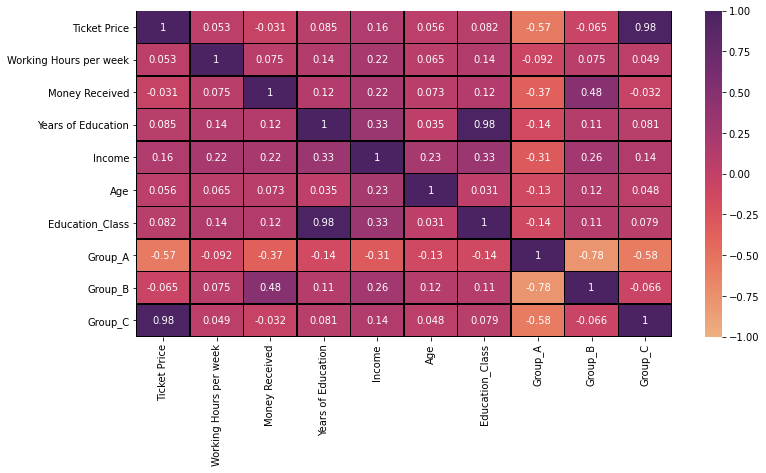

In [30]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'flare', linewidths=0.5, linecolor='black')

In [31]:
#High correlation between Ticket Price and Group_C. We can remove one of then
#Also high correlation between Years of Education and Education class
processedTrainingData = processedTrainingData.drop(['Group_C','Education_Class'],axis=1)

In [32]:
corr_df = processedTrainingData.corr()['Income']
low_corr_cols =[]
for col in list(corr_df.index):
    if(np.abs(corr_df[col]) < 0.1):
        low_corr_cols.append(col)

In [33]:
print(low_corr_cols)
processedTrainingData = processedTrainingData.drop(low_corr_cols,axis=1)

['Native Continent_africa', 'Native Continent_america', 'Native Continent_asia', 'Native Continent_europe', 'Native Continent_oceania', 'Role_administratives', 'Role_agriculture and fishing', 'Role_army', 'Role_cleaners & handlers', 'Role_household services', 'Role_it', 'Role_machine operators & inspectors', 'Role_repair & constructions', 'Role_sales', 'Role_security', 'Role_transports', 'Sector_None', 'Sector_public']


### Outliers

In [34]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(processedTrainingData)
mask = yhat != -1

In [35]:
metrics_df = processedTrainingData.copy()
#specify the 12 metrics column names to be modelled
to_model_columns=[x for x in processedTrainingData.columns if x != 'Income']
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.05), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
metrics_df = metrics_df.reset_index()
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
print(metrics_df['anomaly'].value_counts())

 1    21280
-1     1120
Name: anomaly, dtype: int64


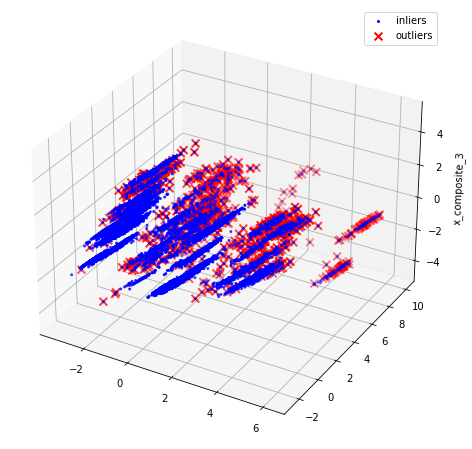

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="blue")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [37]:
yhat = clf.fit_predict(processedTrainingData)
mask = yhat != -1
processedTrainingData = processedTrainingData[mask]

### Split Training Data

In [81]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [82]:
# Backup the Source datasets
X_train_source = X_train.copy()
X_test_source = X_test.copy()
y_train_source = y_train.copy()
y_test_source = y_test.copy()

# MODEL DEFINITION

In [83]:
modellog = LogisticRegression(max_iter=1000000)
modelKNN = KNeighborsClassifier()
modelTree = DecisionTreeClassifier()
modelSVC = SVC()
modelNAB = GaussianNB()
modelRF = RandomForestClassifier()
modelGBC = GradientBoostingClassifier()
modelAda = AdaBoostClassifier()
modelMLP = MLPClassifier(max_iter=500)
modelLDA = LinearDiscriminantAnalysis()
modelBagging = BaggingClassifier()

# Run All Models, without over/under sampling and without scaling

Running Model: LogisticRegression
[[4707  305]
 [ 669  703]]
-- Done. Duration: 39.88898777961731 s
Running Model: KNeighborsClassifier
[[4602  410]
 [ 585  787]]
-- Done. Duration: 8.482361316680908 s
Running Model: DecisionTreeClassifier
[[4530  482]
 [ 615  757]]
-- Done. Duration: 0.5819385051727295 s
Running Model: SVC
[[4957   55]
 [1153  219]]
-- Done. Duration: 52.917699575424194 s
Running Model: GaussianNB
[[3434 1578]
 [ 154 1218]]
-- Done. Duration: 0.3709900379180908 s
Running Model: RandomForestClassifier
[[4629  383]
 [ 583  789]]
-- Done. Duration: 13.624401569366455 s
Running Model: GradientBoostingClassifier
[[4748  264]
 [ 629  743]]
-- Done. Duration: 14.037745475769043 s
Running Model: AdaBoostClassifier
[[4748  264]
 [ 647  725]]
-- Done. Duration: 6.4023942947387695 s
Running Model: LinearDiscriminantAnalysis
[[4704  308]
 [ 674  698]]
-- Done. Duration: 0.7734534740447998 s
Running Model: BaggingClassifier
[[4586  426]
 [ 604  768]]
-- Done. Duration: 3.081345081

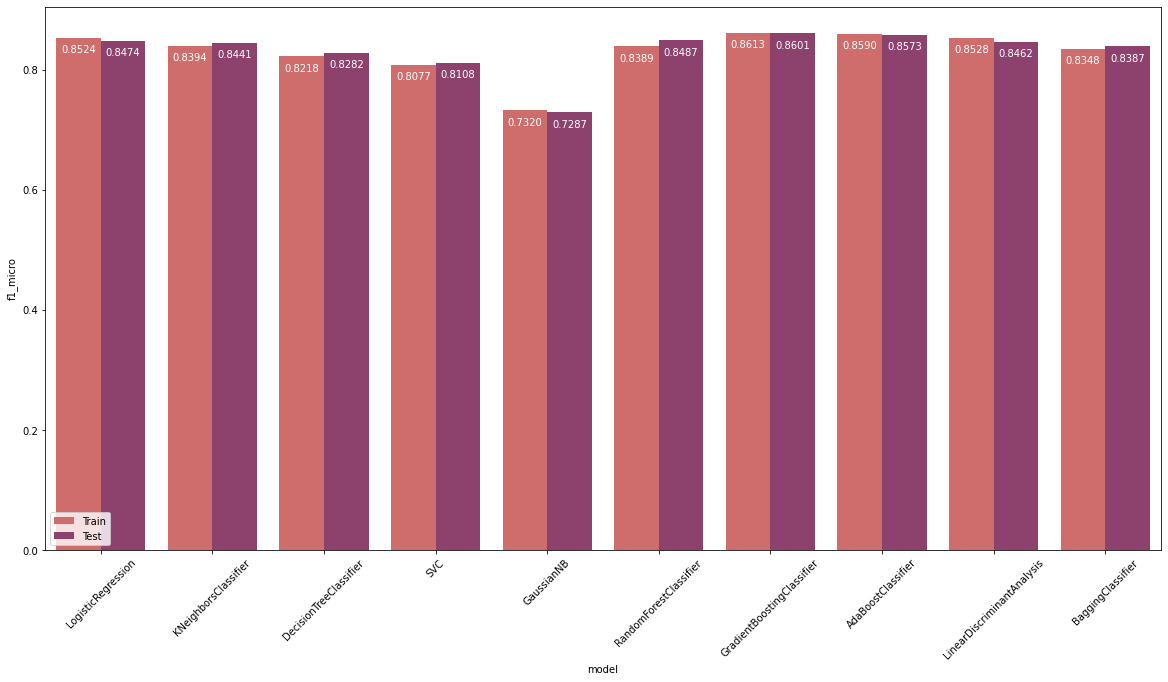

In [84]:
models = [  modellog,
            modelKNN,
            modelTree,
            modelSVC,
            modelNAB,
            modelRF,
            modelGBC,
            modelAda,
            #modelMLP, Too slow, will only put it there in the final version
            modelLDA,
            modelBagging]

DEFAULT_res = runModels(models,X_train,y_train,X_test,y_test)

In [86]:
print_df(DEFAULT_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852443,0.852981,0.852981,0.731466
LogisticRegression,Test,0.847431,0.847431,0.847431,0.725768
KNeighborsClassifier,Train,0.839354,0.884734,0.884734,0.799749
KNeighborsClassifier,Test,0.844142,0.844142,0.844142,0.745906
DecisionTreeClassifier,Train,0.821765,0.951262,0.951262,0.897890
DecisionTreeClassifier,Test,0.828164,0.828164,0.828164,0.727790
SVC,Train,0.807734,0.809345,0.809345,0.572647
SVC,Test,0.810777,0.810777,0.810777,0.574324
GaussianNB,Train,0.732009,0.731673,0.731673,0.786922
GaussianNB,Test,0.728697,0.728697,0.728697,0.786455


## Rebalance Dataset

In [87]:
counter = Counter(y_train)
print(counter)

Counter({0: 11693, 1: 3203})


### Using SMOTE to rebalance dataset

In [47]:
oversample = SMOTE(sampling_strategy=0.4)
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(SMOTE_y_train)
print(counter)

Counter({0: 11693, 1: 4677})


Running Model: LogisticRegression
[[4564  448]
 [ 540  832]]
-- Done. Duration: 35.89853549003601 s
Running Model: RandomForestClassifier
[[4536  476]
 [ 538  834]]
-- Done. Duration: 11.908874273300171 s
Running Model: GradientBoostingClassifier
[[4617  395]
 [ 531  841]]
-- Done. Duration: 11.796404600143433 s
Running Model: AdaBoostClassifier
[[4560  452]
 [ 521  851]]
-- Done. Duration: 5.835913181304932 s
GLOBAL DURATION: 65.43972754478455 s


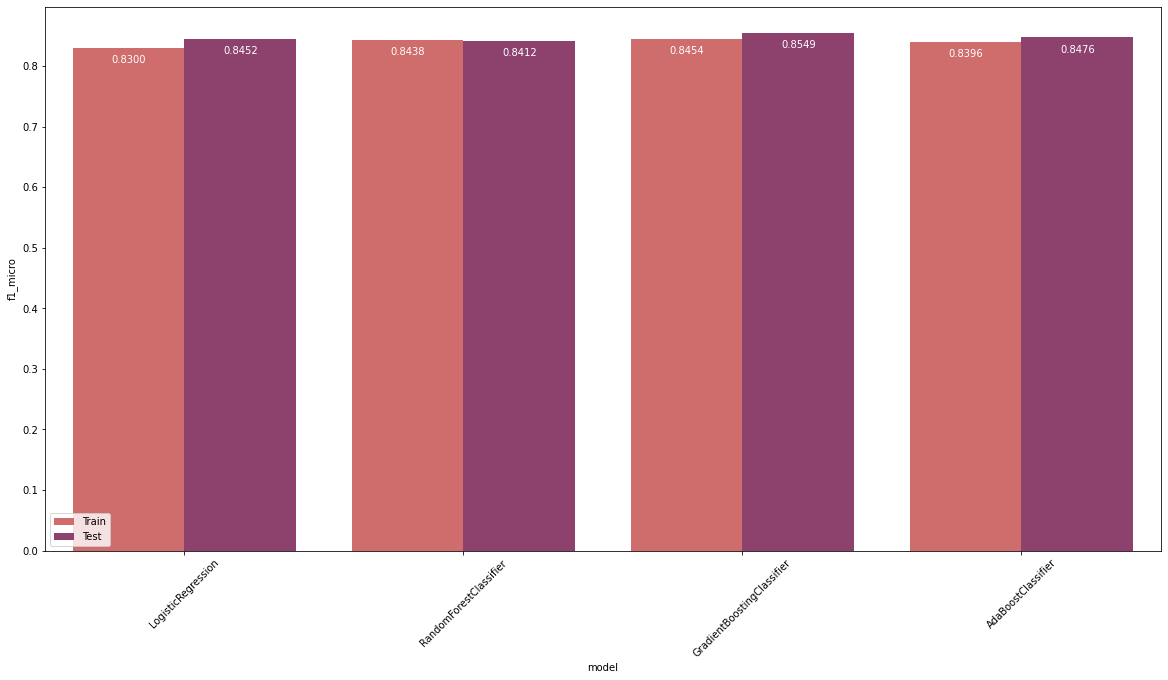

In [48]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

SMOTE_res = runModels(models,SMOTE_X_train,SMOTE_y_train,X_test,y_test)

In [49]:
print_df(SMOTE_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.829994,0.831460,0.831460,0.771693
LogisticRegression,Test,0.845238,0.845238,0.845238,0.758514
RandomForestClassifier,Train,0.843800,0.944349,0.944349,0.925893
RandomForestClassifier,Test,0.841165,0.841165,0.841165,0.756450
GradientBoostingClassifier,Train,0.845449,0.850031,0.850031,0.792518
GradientBoostingClassifier,Test,0.854950,0.854950,0.854950,0.767081
AdaBoostClassifier,Train,0.839585,0.840073,0.840073,0.782405
AdaBoostClassifier,Test,0.847588,0.847588,0.847588,0.765039


### Using ADASYN to rebalance dataset

In [88]:
oversample = ADASYN()
ADASYN_X_train, ADASYN_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(ADASYN_y_train)
print(counter)

Counter({1: 11742, 0: 11693})


Running Model: LogisticRegression
[[3803 1209]
 [ 215 1157]]
-- Done. Duration: 66.21600985527039 s
Running Model: RandomForestClassifier
[[4086  926]
 [ 356 1016]]
-- Done. Duration: 20.023698806762695 s
Running Model: GradientBoostingClassifier
[[3854 1158]
 [ 166 1206]]
-- Done. Duration: 17.19103455543518 s
Running Model: AdaBoostClassifier
[[3939 1073]
 [ 215 1157]]
-- Done. Duration: 7.832614421844482 s
GLOBAL DURATION: 111.26335763931274 s


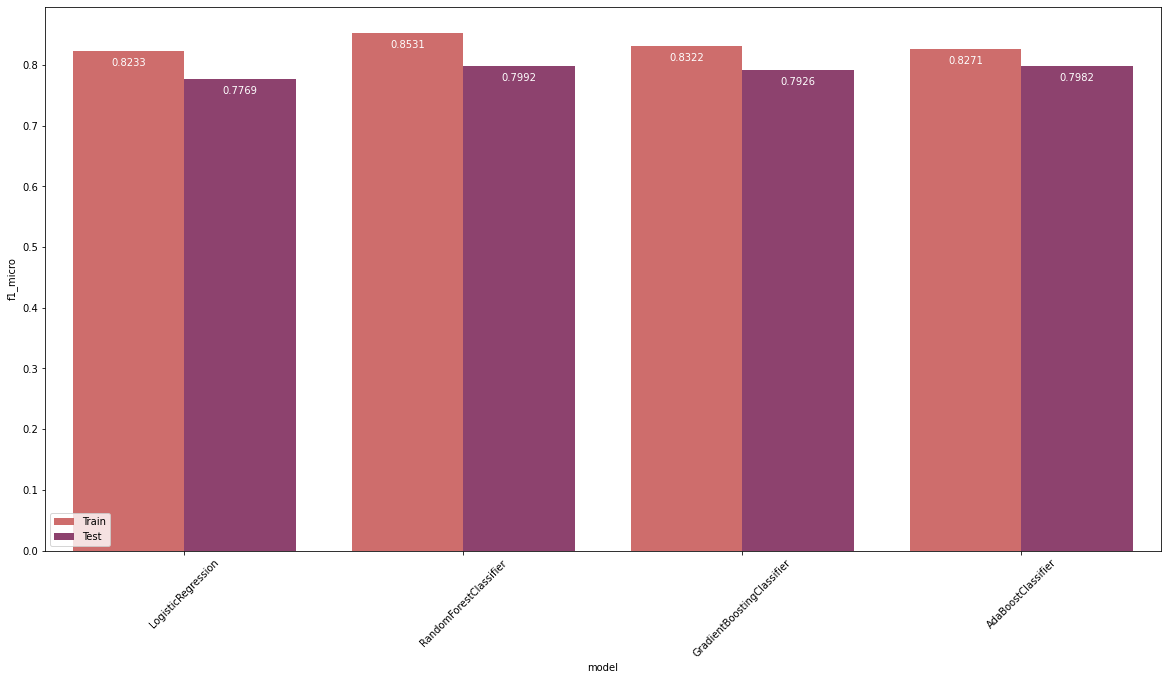

In [89]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

ADASYN_res = runModels(models,ADASYN_X_train,ADASYN_y_train,X_test,y_test)

### Using Random Over Sampler

In [303]:
Counter(y_train)

Counter({0: 11693, 1: 3203})

In [314]:
ROS = RandomOverSampler(sampling_strategy=0.6)
ROS_X_train, ROS_y_train = ROS.fit_resample(X_train, y_train)

counter = Counter(ROS_y_train)
print(counter)

Counter({0: 11693, 1: 7015})


Running Model: LogisticRegression
[[4359  653]
 [ 400  972]]
-- Done. Duration: 36.58954381942749 s
Running Model: RandomForestClassifier
[[4444  568]
 [ 516  856]]
-- Done. Duration: 13.570383787155151 s
Running Model: GradientBoostingClassifier
[[4391  621]
 [ 348 1024]]
-- Done. Duration: 13.463066101074219 s
Running Model: AdaBoostClassifier
[[4352  660]
 [ 341 1031]]
-- Done. Duration: 6.174649000167847 s
GLOBAL DURATION: 69.8132815361023 s


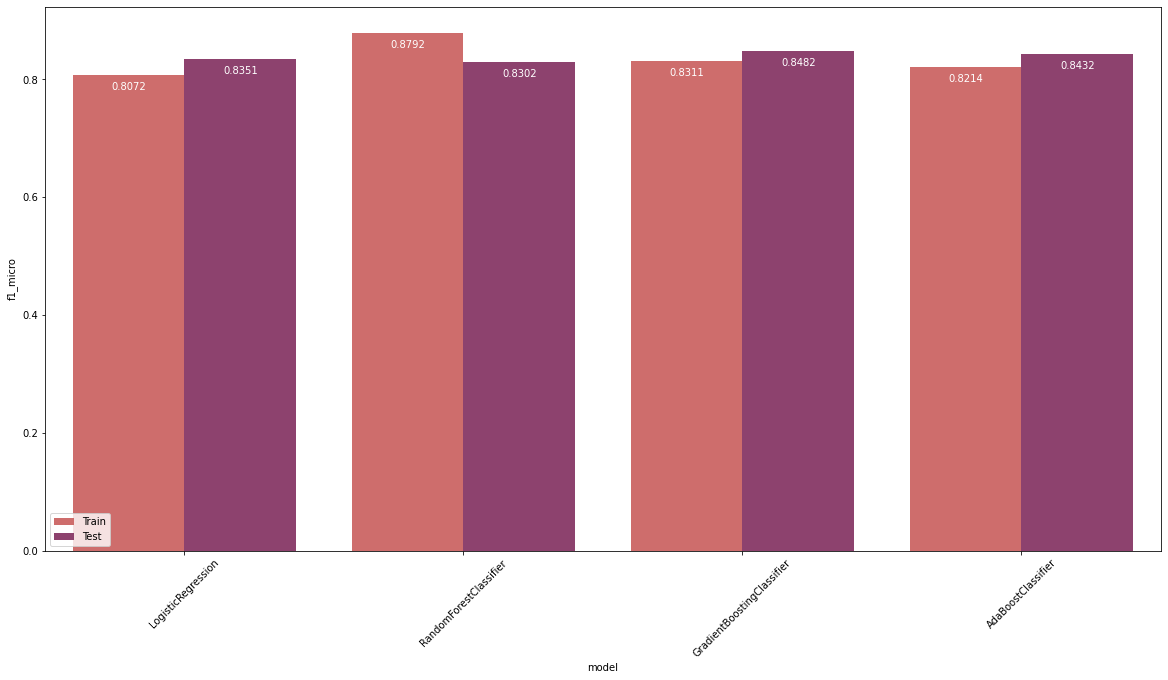

In [315]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

ROS_res = runModels(models,ROS_X_train,ROS_y_train,X_test,y_test)

In [251]:
print_df(ROS_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.824985,0.825168,0.825168,0.762606
LogisticRegression,Test,0.842575,0.842575,0.842575,0.756554
RandomForestClassifier,Train,0.865486,0.949725,0.949725,0.935622
RandomForestClassifier,Test,0.833647,0.833647,0.833647,0.743721
GradientBoostingClassifier,Train,0.843616,0.847465,0.847465,0.796367
GradientBoostingClassifier,Test,0.854950,0.854950,0.854950,0.782168
AdaBoostClassifier,Train,0.838546,0.839218,0.839218,0.782063
AdaBoostClassifier,Test,0.853070,0.853070,0.853070,0.771178


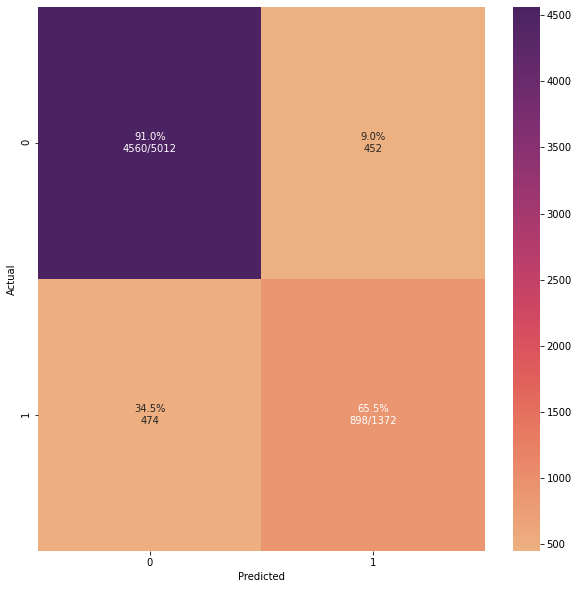

In [252]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### SMOTE and Tomek Links

In [74]:
from imblearn.under_sampling import TomekLinks

oversample = SMOTE(sampling_strategy=0.8)
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)

TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(SMOTE_X_train, SMOTE_y_train)


counter = Counter(TKL_y_train)
print(counter)

Counter({0: 11508, 1: 9355})


Running Model: LogisticRegression
[[4122  889]
 [ 294 1079]]
-- Done. Duration: 51.166971921920776 s
Running Model: RandomForestClassifier
[[4334  677]
 [ 422  951]]
-- Done. Duration: 16.70082950592041 s
Running Model: GradientBoostingClassifier
[[4170  841]
 [ 264 1109]]
-- Done. Duration: 15.531647443771362 s
Running Model: AdaBoostClassifier
[[4099  912]
 [ 255 1118]]
-- Done. Duration: 6.904637336730957 s
GLOBAL DURATION: 90.32069516181946 s


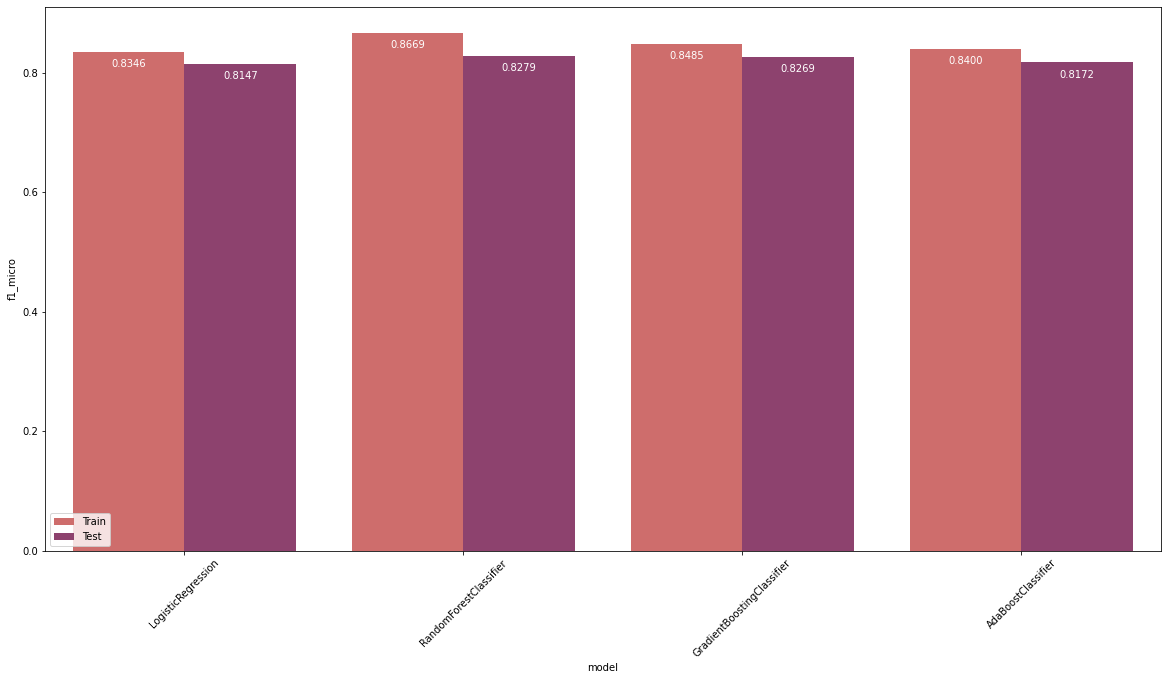

In [75]:
ROUS_res = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

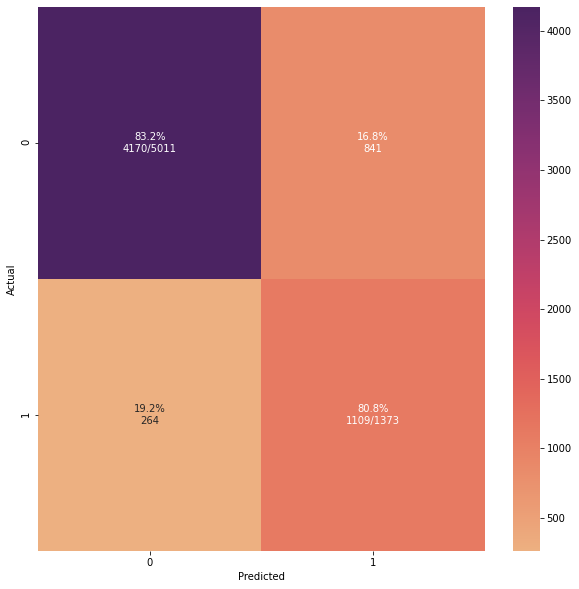

In [76]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Random Under Sampler

In [54]:
RUS = RandomUnderSampler(sampling_strategy=0.3)
ROUS_X_train, ROUS_y_train = RUS.fit_resample(X_train, y_train)

counter = Counter(ROUS_y_train)
print(counter)

Counter({0: 10676, 1: 3203})


Running Model: LogisticRegression
[[3904 1108]
 [ 206 1166]]
-- Done. Duration: 19.907720804214478 s
Running Model: RandomForestClassifier
[[4036  976]
 [ 290 1082]]
-- Done. Duration: 7.8480353355407715 s
Running Model: GradientBoostingClassifier
[[4007 1005]
 [ 190 1182]]
-- Done. Duration: 7.24835991859436 s
Running Model: AdaBoostClassifier
[[3969 1043]
 [ 186 1186]]
-- Done. Duration: 4.428641319274902 s
GLOBAL DURATION: 39.43375825881958 s


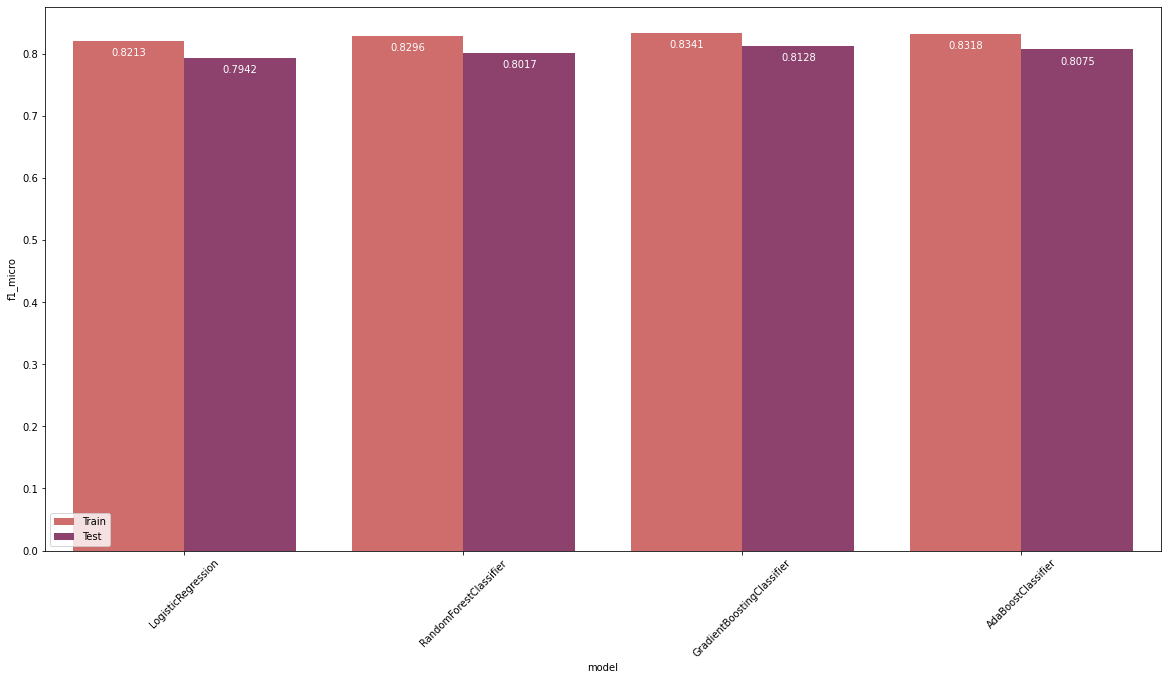

In [51]:
ROUS_res = runModels(models,ROUS_X_train,ROUS_y_train,X_test,y_test)

In [256]:
print_df(ROUS_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.812940,0.813903,0.813903,0.799465
LogisticRegression,Test,0.826598,0.826598,0.826598,0.792166
RandomForestClassifier,Train,0.850948,0.949006,0.949006,0.946846
RandomForestClassifier,Test,0.822055,0.822055,0.822055,0.768099
GradientBoostingClassifier,Train,0.833867,0.838919,0.838919,0.828330
GradientBoostingClassifier,Test,0.840226,0.840226,0.840226,0.807991
AdaBoostClassifier,Train,0.826570,0.827053,0.827053,0.815031
AdaBoostClassifier,Test,0.834900,0.834900,0.834900,0.805394


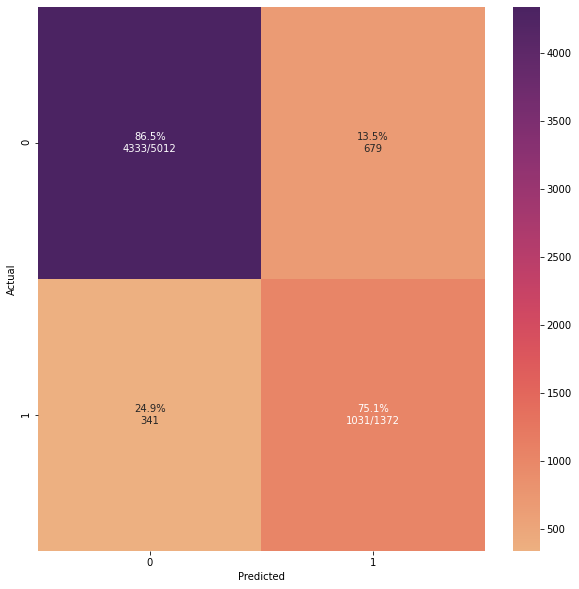

In [257]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Tomek Links to undersample data

In [44]:
from imblearn.under_sampling import TomekLinks
print(counter)
TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(X_train, y_train)

counter = Counter(TKL_y_train)
print(counter)

Counter({0: 11693, 1: 3203})
Counter({0: 11414, 1: 3203})


Running Model: LogisticRegression
[[4697  315]
 [ 664  708]]
-- Done. Duration: 30.595375537872314 s
Running Model: RandomForestClassifier
[[4584  428]
 [ 596  776]]
-- Done. Duration: 11.21304440498352 s
Running Model: GradientBoostingClassifier
[[4747  265]
 [ 621  751]]
-- Done. Duration: 10.509834289550781 s
Running Model: AdaBoostClassifier
[[4697  315]
 [ 612  760]]
-- Done. Duration: 4.884068965911865 s
GLOBAL DURATION: 57.203282594680786 s


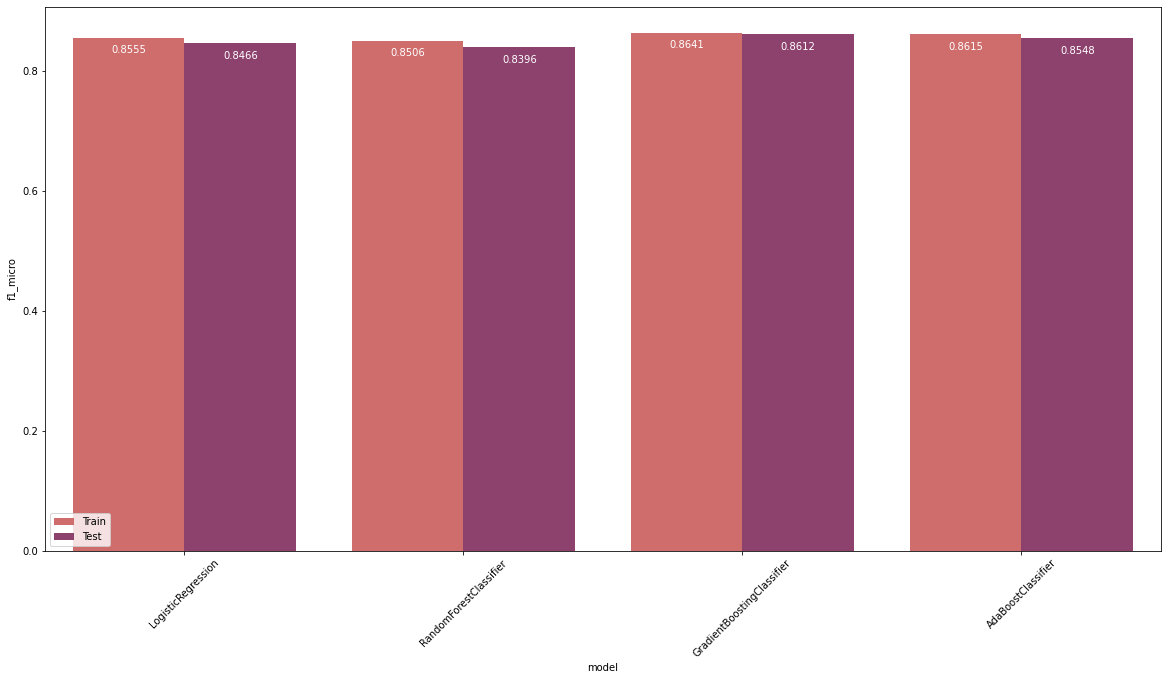

In [45]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

TKL_res = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

In [46]:
print_df(TKL_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.855511,0.854895,0.854895,0.742796
LogisticRegression,Test,0.846648,0.846648,0.846648,0.726593
RandomForestClassifier,Train,0.850585,0.952453,0.952453,0.912283
RandomForestClassifier,Test,0.839599,0.839599,0.839599,0.740101
GradientBoostingClassifier,Train,0.864063,0.868578,0.868578,0.762001
GradientBoostingClassifier,Test,0.861216,0.861216,0.861216,0.747251
AdaBoostClassifier,Train,0.861531,0.863241,0.863241,0.756563
AdaBoostClassifier,Test,0.854793,0.854793,0.854793,0.745543


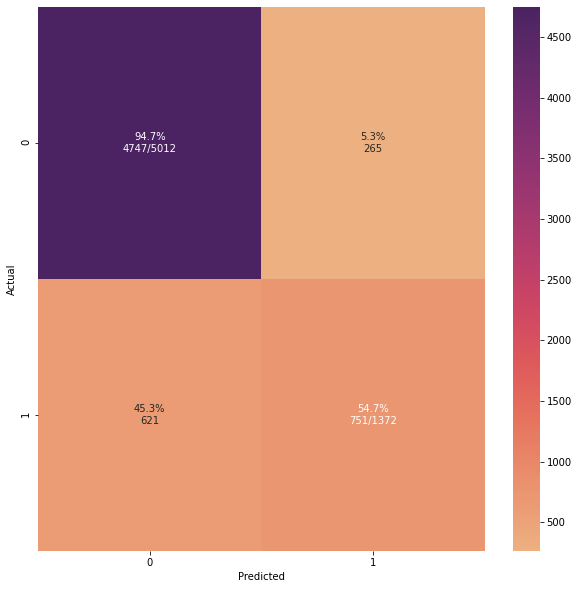

In [47]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Combine Tomek Links with Random OverSampling to undersample data

In [235]:
ROS = RandomOverSampler(sampling_strategy=0.3)
TLRO_X_train, TLRO_y_train = ROS.fit_resample(TKL_X_train, TKL_y_train )
counter = Counter(TLRO_y_train)
print(counter)

Counter({0: 11401, 1: 3420})


Running Model: LogisticRegression
[[5011    0]
 [1290   83]]
-- Done. Duration: 34.9092583656311 s
Running Model: RandomForestClassifier
[[5010    1]
 [1225  148]]
-- Done. Duration: 2.0681726932525635 s
Running Model: GradientBoostingClassifier
[[5010    1]
 [1225  148]]
-- Done. Duration: 10.471034526824951 s
Running Model: AdaBoostClassifier
[[5011    0]
 [1293   80]]
-- Done. Duration: 4.5365705490112305 s
GLOBAL DURATION: 51.98503613471985 s


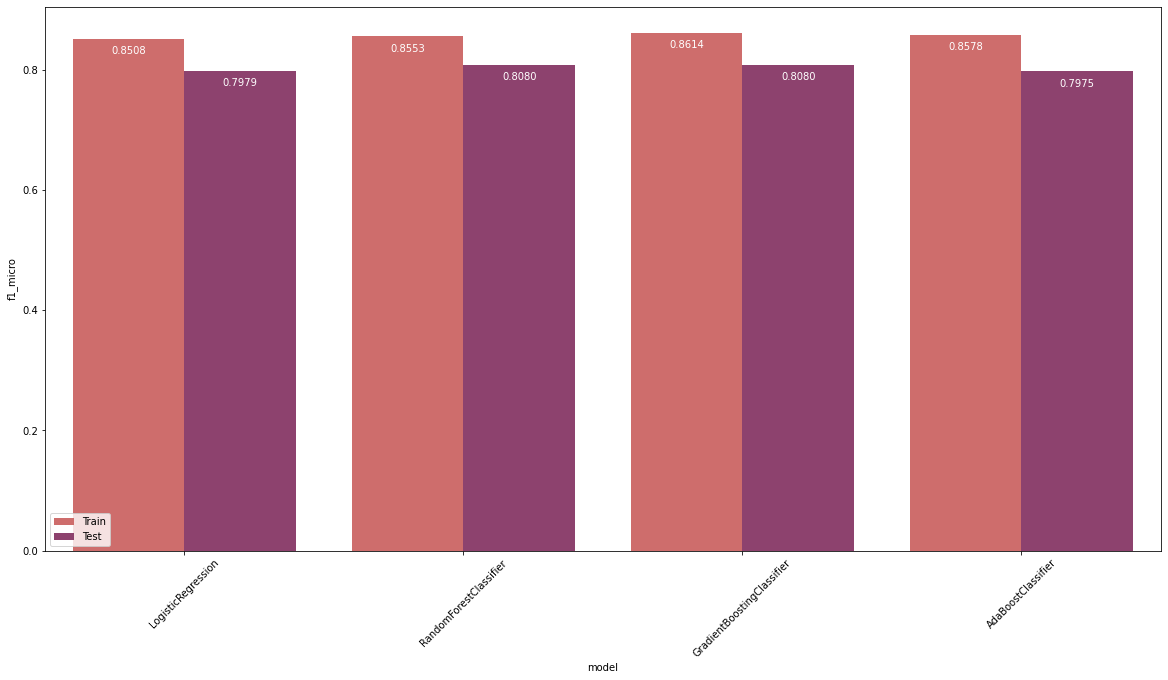

In [236]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

TLRO_res = runModels(models,TLRO_X_train,TLRO_y_train,X_test,y_test)

No Skill: ROC AUC=0.500
GradientBoostingClassifier  : ROC AUC=0.906


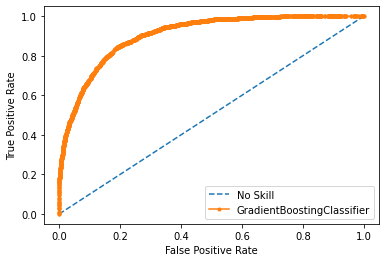

In [145]:
plot_roc_auc(modelGBC,X_test,y_test)

GradientBoostingClassifier  : f1=0.634 auc=0.753


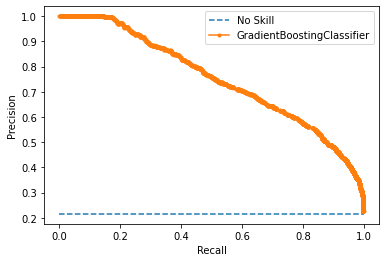

In [146]:
plot_precision_recall(modelGBC,X_test,y_test)

In [141]:
print_df(TLRO_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.849942,0.850415,0.850415,0.749257
LogisticRegression,Test,0.845865,0.845865,0.845865,0.734196
RandomForestClassifier,Train,0.852844,0.952028,0.952028,0.920513
RandomForestClassifier,Test,0.839442,0.839442,0.839442,0.746232
GradientBoostingClassifier,Train,0.861818,0.866271,0.866271,0.770002
GradientBoostingClassifier,Test,0.859179,0.859179,0.859179,0.752988
AdaBoostClassifier,Train,0.856420,0.857702,0.857702,0.764535
AdaBoostClassifier,Test,0.853853,0.853853,0.853853,0.751710


### Using NearMiss to undersample data

In [147]:
from imblearn.under_sampling import AllKNN

NM = NearMiss(version=1,sampling_strategy=0.3)
NM_X_train, NM_y_train = NM.fit_resample(X_train, y_train)

counter = Counter(NM_y_train)
print(counter)

Counter({0: 10673, 1: 3202})


Running Model: LogisticRegression
[[4563  448]
 [ 646  727]]
-- Done. Duration: 49.44913029670715 s
Running Model: RandomForestClassifier
[[4443  568]
 [ 589  784]]
-- Done. Duration: 11.274465084075928 s
Running Model: GradientBoostingClassifier
[[4564  447]
 [ 614  759]]
-- Done. Duration: 10.420936822891235 s
Running Model: AdaBoostClassifier
[[4586  425]
 [ 621  752]]
-- Done. Duration: 4.547105073928833 s
GLOBAL DURATION: 75.69163727760315 s


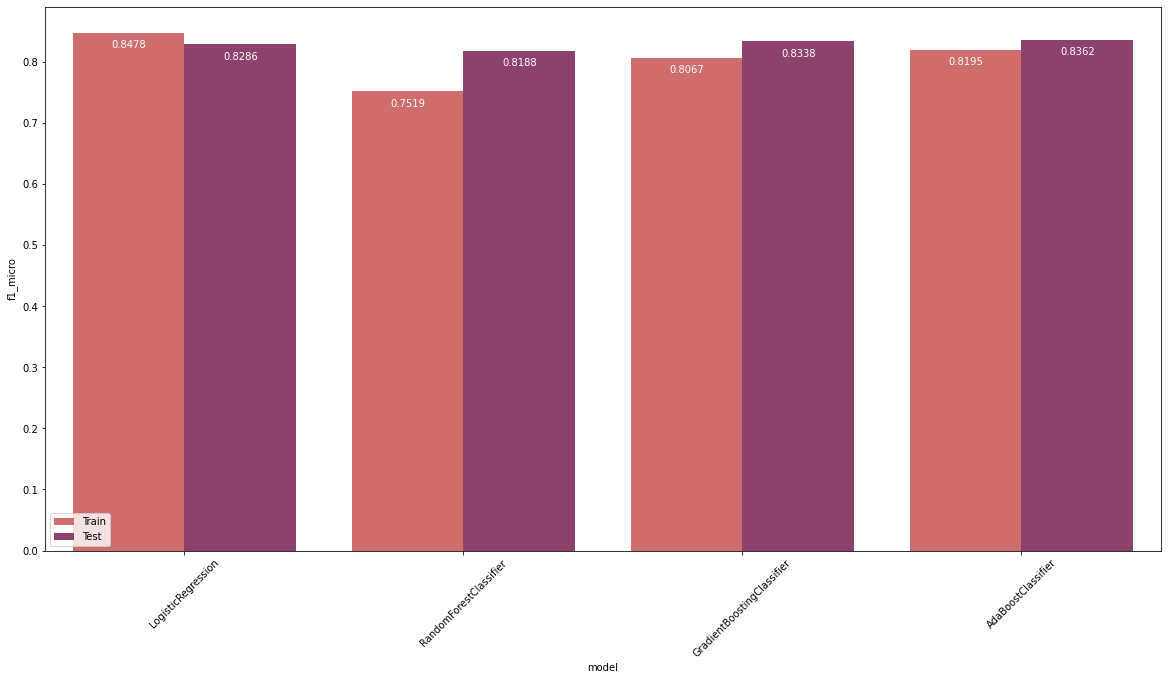

In [148]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

NM_res = runModels(models,NM_X_train,NM_y_train,X_test,y_test)

### Choose 1 method

In [90]:
X_train = TKL_X_train
y_train = TKL_y_train
X_test  = X_test_source
y_test = y_test_source

## Data Scaling

### StandardScaler

In [324]:
scaler = StandardScaler()
SScale_X_train = scaler.fit_transform(X_train)
SScale_X_test = scaler.fit_transform(X_test)
SScale_y_train = y_train
SScale_y_test = y_test

Running Model: LogisticRegression
[[4732  280]
 [ 653  719]]
-- Done. Duration: 1.0561003684997559 s
Running Model: RandomForestClassifier
[[4582  430]
 [ 607  765]]
-- Done. Duration: 10.72249460220337 s
Running Model: GradientBoostingClassifier
[[4737  275]
 [ 651  721]]
-- Done. Duration: 10.984318733215332 s
Running Model: AdaBoostClassifier
[[4726  286]
 [ 655  717]]
-- Done. Duration: 4.732580184936523 s
GLOBAL DURATION: 27.49549388885498 s


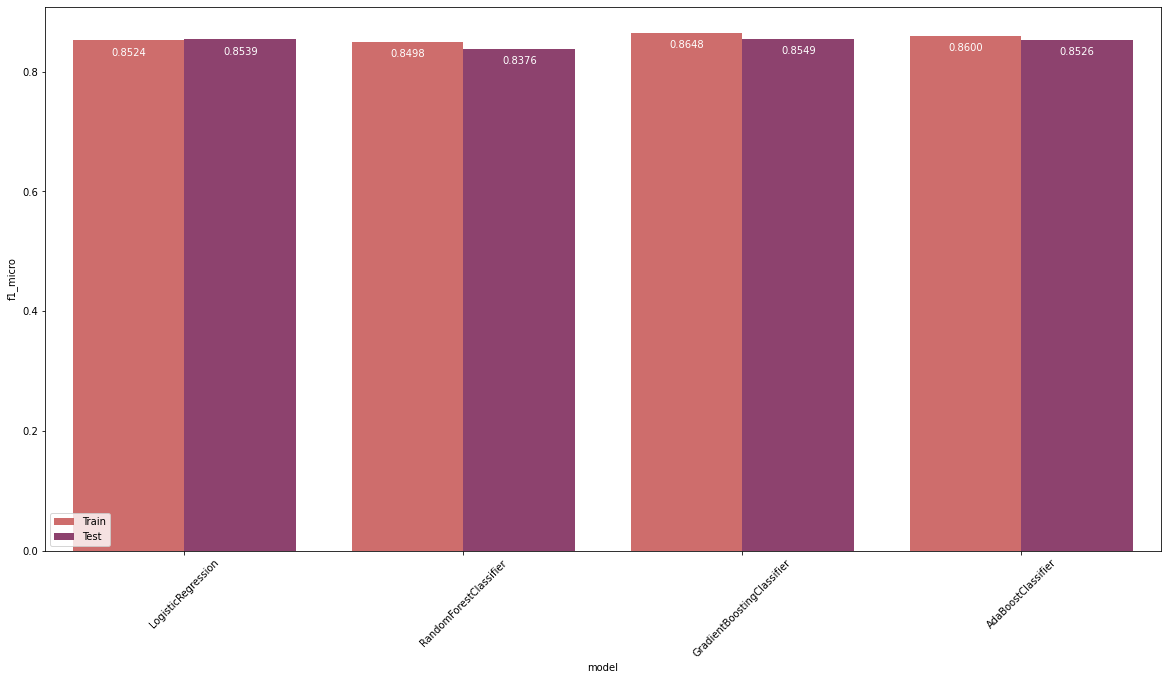

In [325]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

SScaler_res = runModels(models,SScale_X_train,SScale_y_train,SScale_X_test,SScale_y_test)

In [326]:
SScaler_res.style.hide_index()

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852374,0.852442,0.852442,0.740997
LogisticRegression,Test,0.853853,0.853853,0.853853,0.734093
RandomForestClassifier,Train,0.849775,0.951840,0.951840,0.914248
RandomForestClassifier,Test,0.837563,0.837563,0.837563,0.735893
GradientBoostingClassifier,Train,0.864825,0.868792,0.868792,0.761461
GradientBoostingClassifier,Test,0.854950,0.854950,0.854950,0.735321
AdaBoostClassifier,Train,0.859968,0.862977,0.862977,0.754930
AdaBoostClassifier,Test,0.852600,0.852600,0.852600,0.732766


### MinMax 0:1

In [78]:
min_max_0_1 = MinMaxScaler(feature_range=(0, 1))
MinMaxScaler_01_X_train = min_max_0_1.fit_transform(X_train)
MinMaxScaler_01_X_test = min_max_0_1.fit_transform(X_test)
MinMaxScaler_01_y_train = y_train
MinMaxScaler_01_y_test = y_test

Running Model: LogisticRegression
[[4106  905]
 [ 285 1088]]
-- Done. Duration: 4.043544292449951 s
Running Model: RandomForestClassifier
[[4337  674]
 [ 461  912]]
-- Done. Duration: 15.335784196853638 s
Running Model: GradientBoostingClassifier
[[4147  864]
 [ 293 1080]]
-- Done. Duration: 15.963878393173218 s
Running Model: AdaBoostClassifier
[[4089  922]
 [ 261 1112]]
-- Done. Duration: 6.9882519245147705 s
GLOBAL DURATION: 42.33347749710083 s


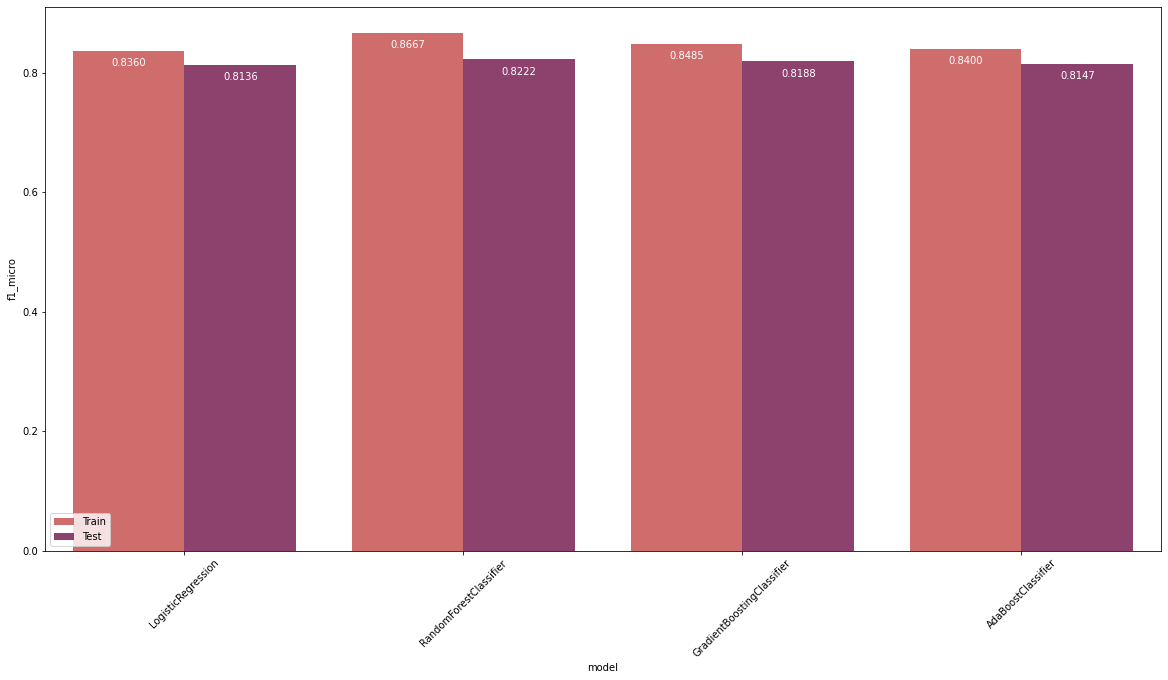

In [79]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_01_res = runModels(models,MinMaxScaler_01_X_train,MinMaxScaler_01_y_train,MinMaxScaler_01_X_test,MinMaxScaler_01_y_test)

### MinMax -1:1

In [49]:
min_max_1_1 = MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler_11_X_train = min_max_1_1.fit_transform(X_train)
MinMaxScaler_11_X_test = min_max_1_1.fit_transform(X_test)
MinMaxScaler_11_y_train = y_train
MinMaxScaler_11_y_test = y_test

Running Model: LogisticRegression
[[4692  320]
 [ 658  714]]
-- Done. Duration: 3.7767558097839355 s
Running Model: RandomForestClassifier
[[4587  425]
 [ 585  787]]
-- Done. Duration: 11.336663246154785 s
Running Model: GradientBoostingClassifier
[[4749  263]
 [ 624  748]]
-- Done. Duration: 12.178245306015015 s
Running Model: AdaBoostClassifier
[[4697  315]
 [ 612  760]]
-- Done. Duration: 5.085486650466919 s
GLOBAL DURATION: 32.377151012420654 s


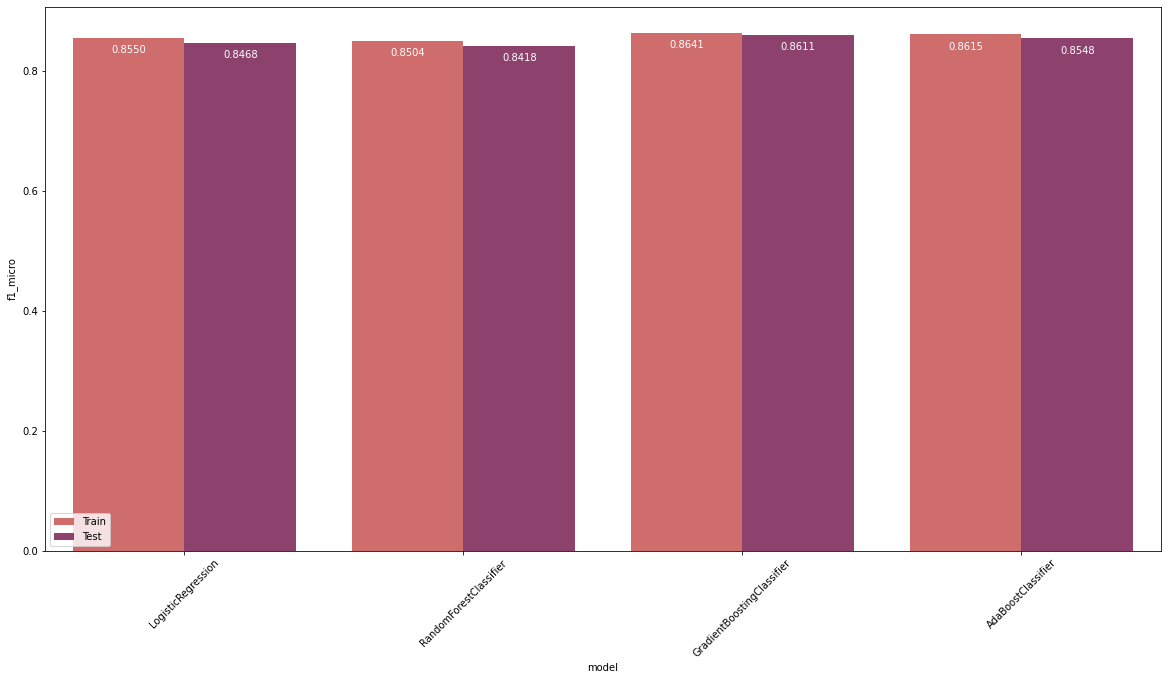

In [50]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_11_res = runModels(models,MinMaxScaler_11_X_train,MinMaxScaler_11_y_train,MinMaxScaler_11_X_test,MinMaxScaler_11_y_test)

In [91]:
print_df(MinMaxScaler_11_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.855032,0.855716,0.855716,0.744332
LogisticRegression,Test,0.846805,0.846805,0.846805,0.728281
RandomForestClassifier,Train,0.850448,0.952521,0.952521,0.914011
RandomForestClassifier,Test,0.841792,0.841792,0.841792,0.744409
GradientBoostingClassifier,Train,0.864063,0.868304,0.868304,0.761601
GradientBoostingClassifier,Test,0.861059,0.861059,0.861059,0.746358
AdaBoostClassifier,Train,0.861531,0.863241,0.863241,0.756563
AdaBoostClassifier,Test,0.854793,0.854793,0.854793,0.745543


### RobustScaler

In [331]:
robust_scaler = RobustScaler()
RobScaler_X_train = robust_scaler.fit_transform(X_train)
RobScaler_X_test = robust_scaler.fit_transform(X_test)
RobScaler_y_train = y_train
RobScaler_y_test = y_test

Running Model: LogisticRegression
[[4735  277]
 [ 654  718]]
-- Done. Duration: 11.396081686019897 s
Running Model: RandomForestClassifier
[[4613  399]
 [ 593  779]]
-- Done. Duration: 10.32079291343689 s
Running Model: GradientBoostingClassifier
[[4762  250]
 [ 629  743]]
-- Done. Duration: 11.936925411224365 s
Running Model: AdaBoostClassifier
[[4757  255]
 [ 622  750]]
-- Done. Duration: 4.519431114196777 s
GLOBAL DURATION: 38.17323112487793 s


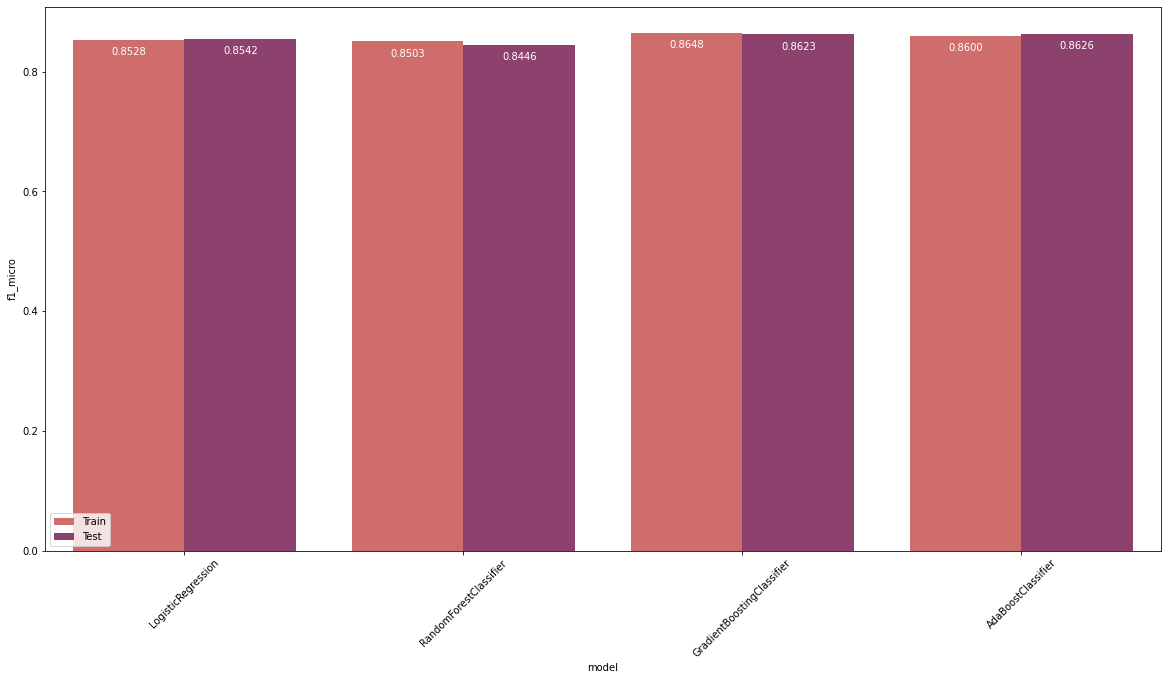

In [332]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

RobScaler_res = runModels(models,RobScaler_X_train,RobScaler_y_train,RobScaler_X_test,RobScaler_y_test)

In [333]:
RobScaler_res.style.hide_index()

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852784,0.852853,0.852853,0.742383
LogisticRegression,Test,0.854167,0.854167,0.854167,0.734028
RandomForestClassifier,Train,0.850322,0.951840,0.951840,0.913911
RandomForestClassifier,Test,0.844612,0.844612,0.844612,0.744088
GradientBoostingClassifier,Train,0.864825,0.868792,0.868792,0.761461
GradientBoostingClassifier,Test,0.862312,0.862312,0.862312,0.745832
AdaBoostClassifier,Train,0.859968,0.862977,0.862977,0.754930
AdaBoostClassifier,Test,0.862625,0.862625,0.862625,0.747885


In [92]:
# Choosing one:
X_train = MinMaxScaler_11_X_train
y_train = MinMaxScaler_11_y_train
X_test = MinMaxScaler_11_X_test
y_test = MinMaxScaler_11_y_test

## Feature Selection
In this section, we will eliminate noise from the model.

In [185]:
from itertools import compress
select = SelectFromModel(modelRF, threshold='mean',prefit=True)
feature_index = [i for i in range(X_train.shape[1])]
features = list(compress(feature_index, select.get_support())) 
X.columns[features]

Index(['Years of Education', 'Money Received', 'Age', 'MStatus_married',
       'MStatus_not_married', 'Lwith_spouse'],
      dtype='object')

<AxesSubplot:xlabel='Value', ylabel='Col'>

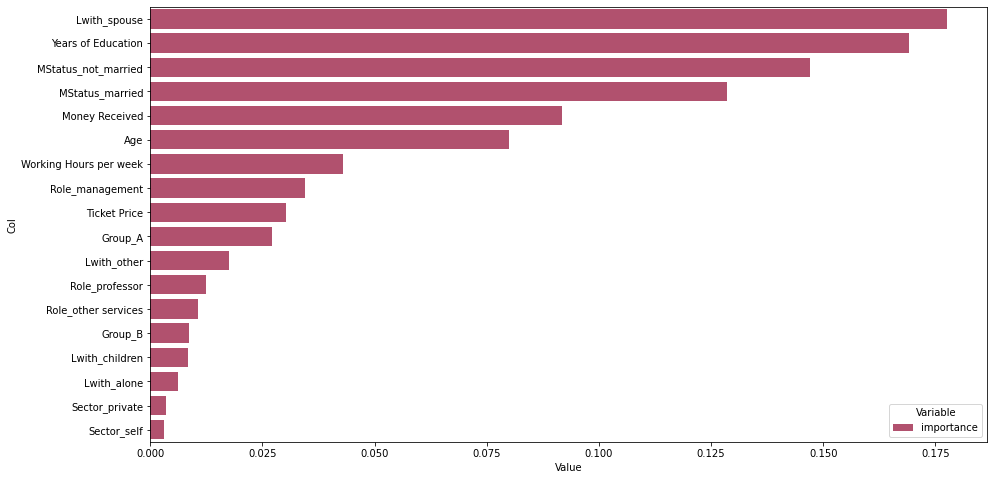

In [186]:
import seaborn as sns
columns = processedTrainingData.columns
zippy = pd.DataFrame(modelRF.feature_importances_, columns = ['importance'])
zippy['col'] = X.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy, palette='flare')

In [187]:
#features = tidy[0:10].index

Running Model: GradientBoostingClassifier
[[4676  336]
 [ 594  778]]
-- Done. Duration: 50.20409393310547 s
Running Model: AdaBoostClassifier
[[4679  333]
 [ 606  766]]
-- Done. Duration: 121.02284932136536 s
GLOBAL DURATION: 171.22694325447083 s


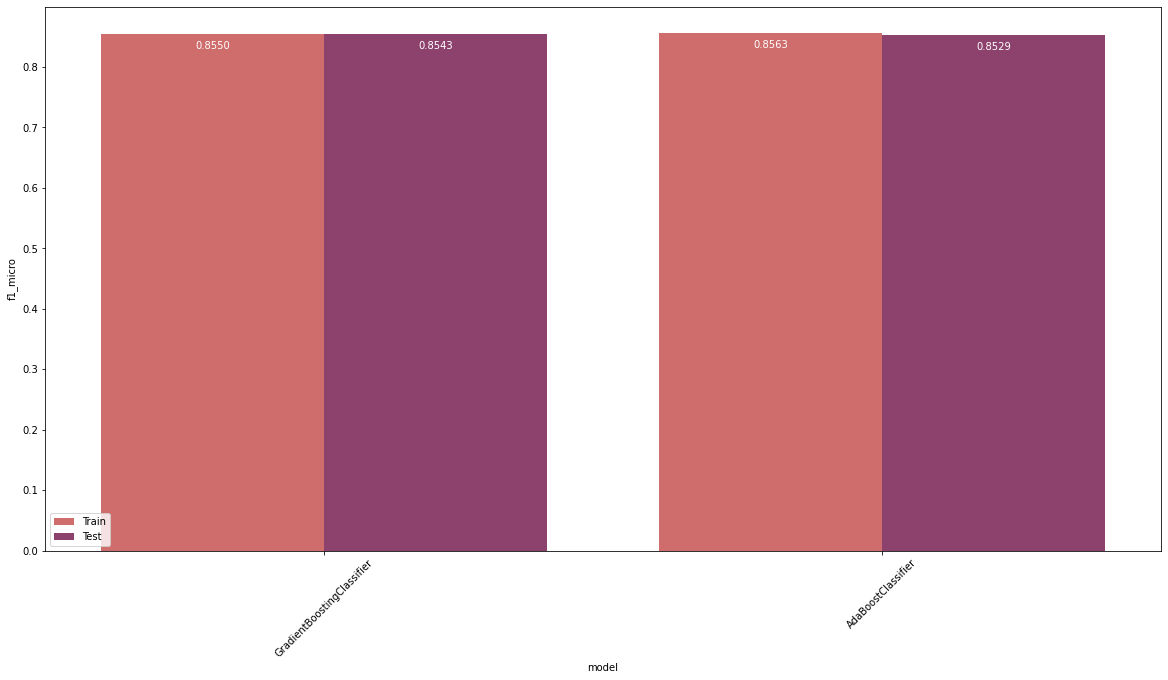

In [188]:
Selected_X_train = X_train[:,features]
Selected_X_test = X_test[:,features]
Selected_y_train = y_train
Selected_y_Test = y_test


select_RES, models = runModels(models,Selected_X_train,Selected_y_train,Selected_X_test,Selected_y_Test)

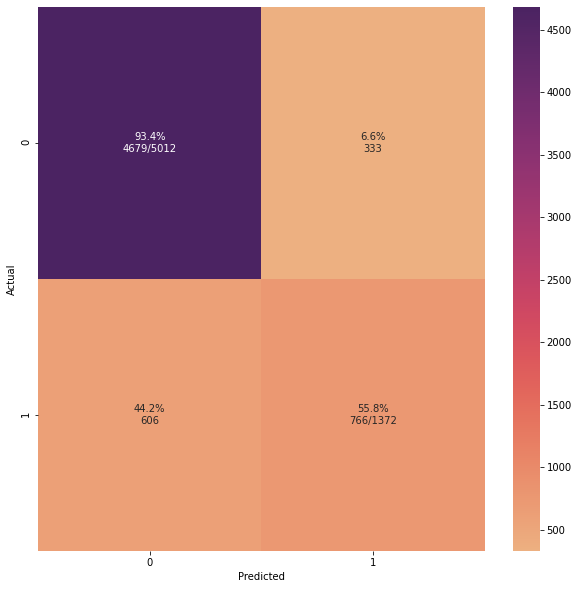

In [189]:
modelAda = models[1]
modelGBC = models[0]
y_pred = modelAda.predict(Selected_X_test)
cm_analysis(Selected_y_Test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

### Hyperpatameterization

In [190]:
hyperopt_X_train = Selected_X_train
hyperopt_y_train = Selected_y_train
hyperopt_X_test = Selected_X_test
hyperopt_y_test = Selected_y_Test

In [191]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)},
             scoring='f1_micro')

In [192]:
 gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.855168569667522)

In [193]:
n_estimators = 80
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='f1_micro')

In [194]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 11, 'min_samples_split': 800}, 0.8564001108244298)

In [196]:
max_depth =11
min_samples_split=800
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt',min_samples_split=min_samples_split, subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='f1_micro',n_jobs=4, cv=5)
gsearch3.fit(hyperopt_X_train, hyperopt_y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 2000}, 0.8559210806505131)

In [197]:
min_samples_leaf = 30
min_samples_split = 2000
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt', n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10),
param_grid = param_test5, scoring='f1_micro',n_jobs=4, cv=5)
gsearch5.fit(hyperopt_X_train, hyperopt_y_train)
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.8559210806505131)

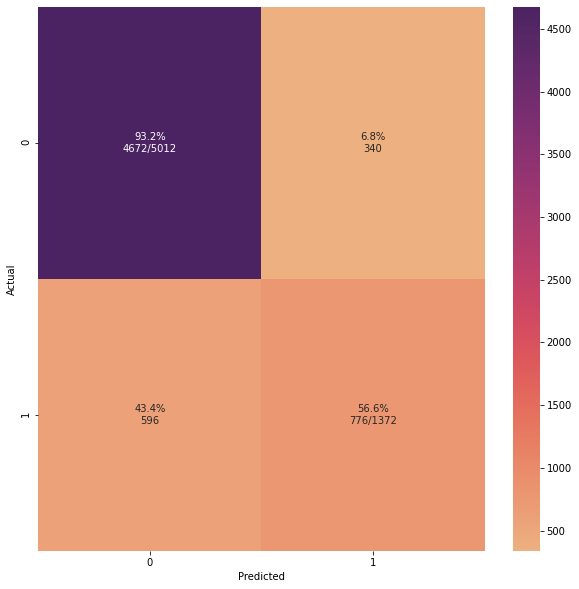

In [198]:
subsample = 0.8
modelGB =  GradientBoostingClassifier(learning_rate=0.1,subsample=subsample,max_features='sqrt', n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

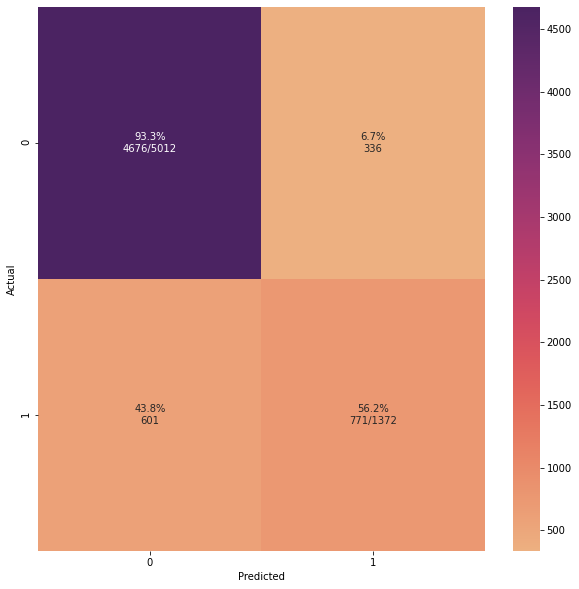

In [199]:
modelGB =  GradientBoostingClassifier(learning_rate=0.5,subsample=subsample,max_features='sqrt', n_estimators=140,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

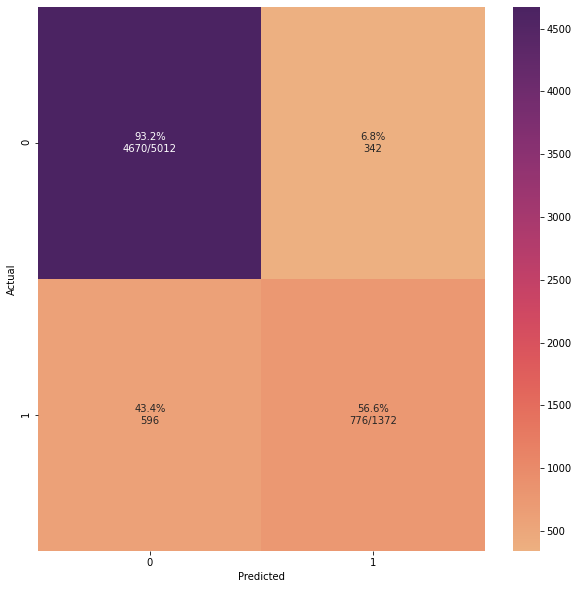

In [201]:
modelGB =  GradientBoostingClassifier(learning_rate=0.005,subsample=subsample,max_features='sqrt', n_estimators=1500,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

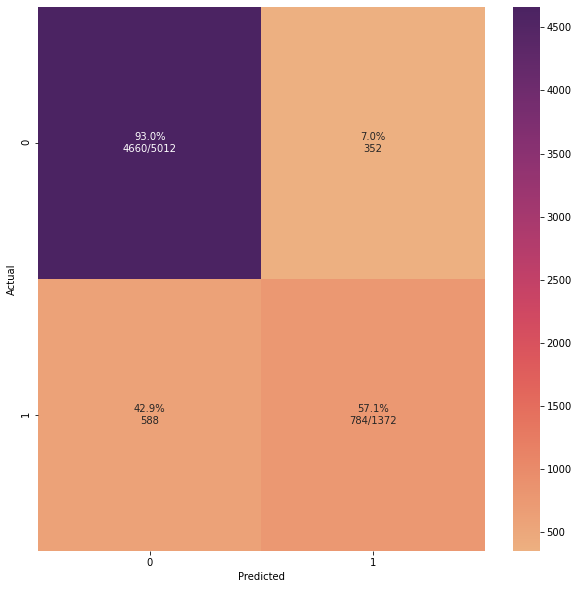

In [229]:
modelGB =  GradientBoostingClassifier(learning_rate=0.02,subsample=subsample,max_features='sqrt', n_estimators=900,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

In [173]:
from sklearn.model_selection import KFold
ada=AdaBoostClassifier()
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}
modelAda=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='f1_micro',n_jobs=1,cv=crossvalidation)
modelAda.fit(hyperopt_X_train, hyperopt_y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [500, 1000, 2000]},
             scoring='f1_micro')

In [230]:
modelAda.best_params_

AttributeError: 'AdaBoostClassifier' object has no attribute 'best_params_'

In [231]:
modelAda=AdaBoostClassifier(learning_rate=0.1,n_estimators=2000)
modelGB =  GradientBoostingClassifier(learning_rate=0.02,subsample=subsample,max_features='sqrt', n_estimators=900,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)

Running Model: GradientBoostingClassifier
[[4660  352]
 [ 588  784]]
-- Done. Duration: 56.99823594093323 s
Running Model: AdaBoostClassifier
[[4679  333]
 [ 606  766]]
-- Done. Duration: 122.08285665512085 s
GLOBAL DURATION: 179.08109259605408 s


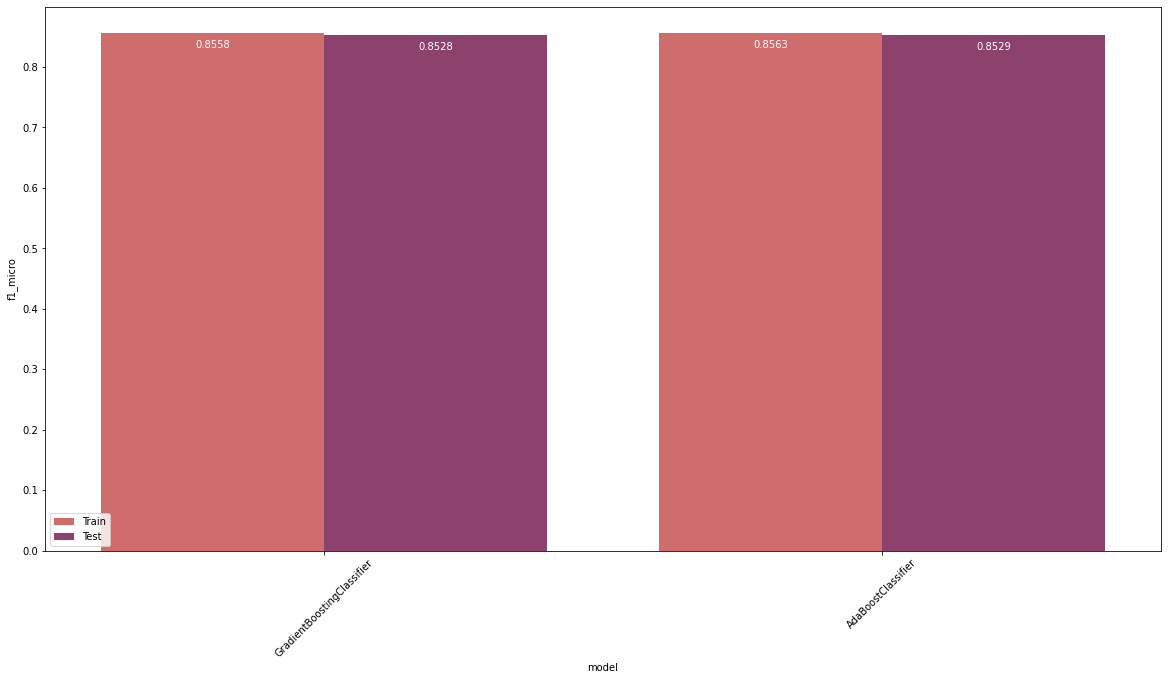

In [232]:
models = [modelGB,modelAda]
hyper_res, models = runModels(models,hyperopt_X_train,hyperopt_y_train,hyperopt_X_test,hyperopt_y_test)

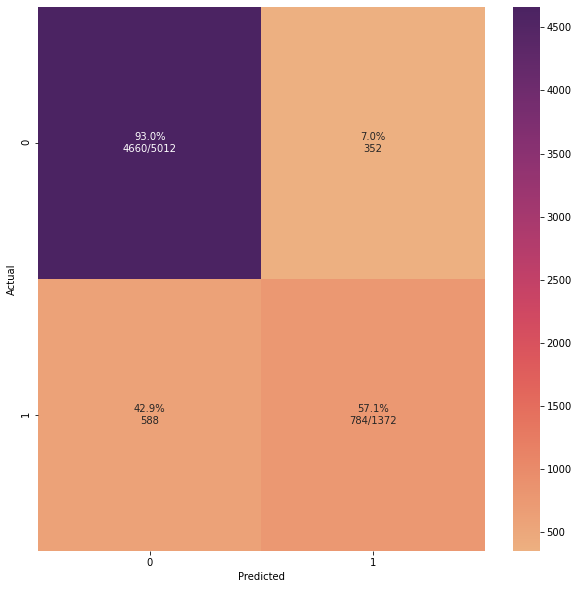

In [233]:
modelGB = models[0]
modelAda = models[1]
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

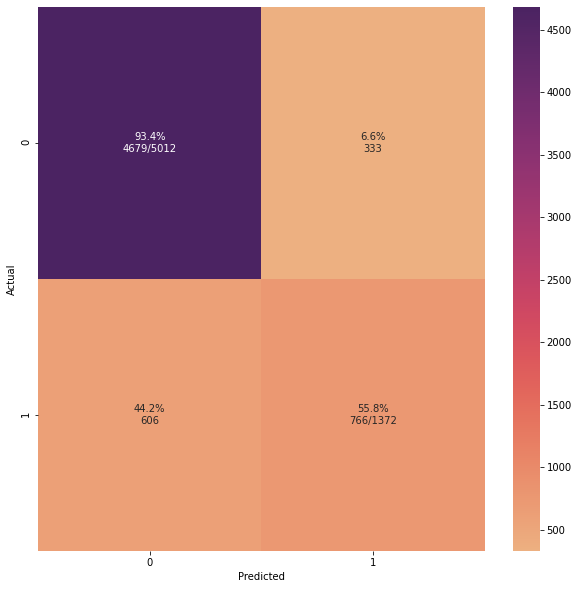

In [234]:
y_pred = modelAda.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

In [235]:
print_df(hyper_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
GradientBoostingClassifier,Train,0.855785,0.859068,0.859068,0.755912
GradientBoostingClassifier,Test,0.852757,0.852757,0.852757,0.750599
AdaBoostClassifier,Train,0.856332,0.857700,0.857700,0.751555
AdaBoostClassifier,Test,0.852914,0.852914,0.852914,0.745934


# Choose a model here, so that the next step is always consistent


In [236]:
MODEL_CHOSEN = modelGB

## Produce File for Submission

In [237]:
prepped_data_submission = DataPreProcessing(data_test)
prepped_data_submission = AlignDataframe(X_train_source.columns,prepped_data_submission)

Scaled_Submission_Data = pd.DataFrame(min_max_1_1.transform(prepped_data_submission), 
                                      index=prepped_data_submission.index, 
                                      columns=prepped_data_submission.columns)

In [238]:
columns_indexes = Scaled_Submission_Data.columns[features]
Scaled_Submission_Data = Scaled_Submission_Data[columns_indexes]
predictions = MODEL_CHOSEN.predict(Scaled_Submission_Data)
Scaled_Submission_Data['Income'] = predictions
Scaled_Submission_Data[['Income']].to_csv('Group10_Version26.csv')